# Culvert with Adverse Slope

In this article, I will compare the results of a culvert with negative slope among HY8, HECRAS, SWMM5 and XPSWMM.

Below is how [HDS5](https://www.fhwa.dot.gov/engineering/hydraulics/pubs/12026/hif12026.pdf) handles adverse slopes in culverts.

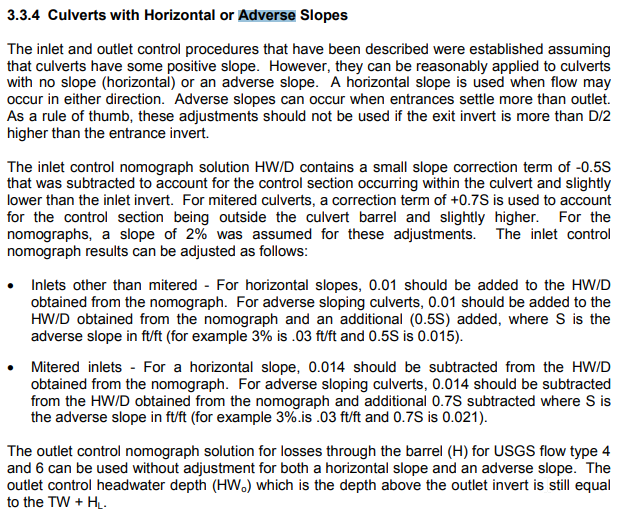

# HY8

HY8 is the "offical" implementation of the FWHA culvert calculation.

The model is saved to : **./data/hy8/negative_slope.hy8**




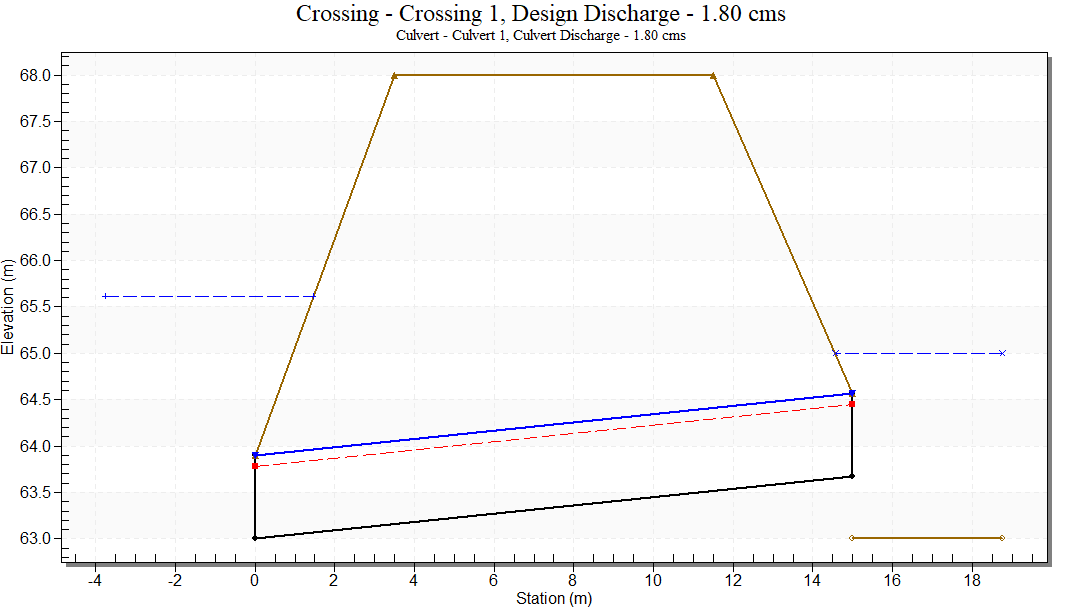

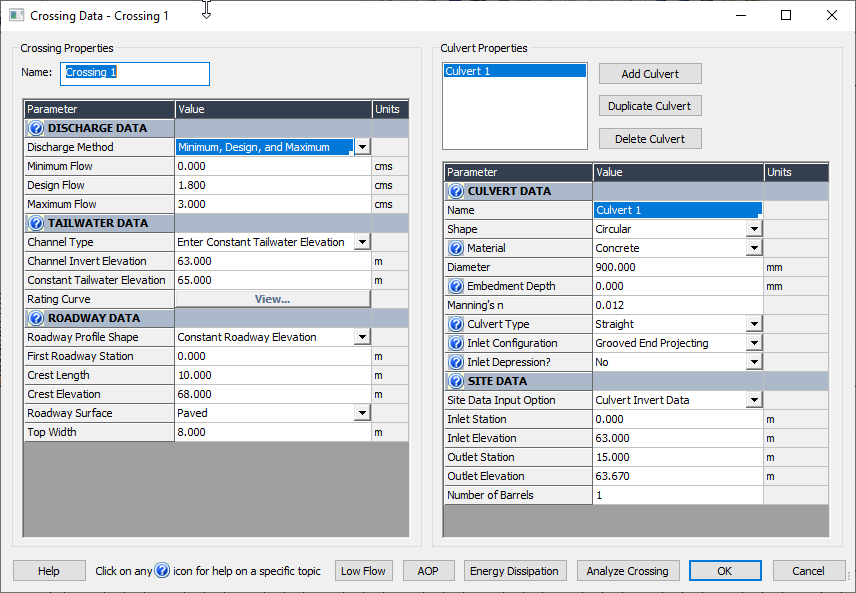

# HY8 Peformance Curve

The curve data is copy and pasted to this file, TODO UPDATE IT: **./data/hy8/negative_slope_performance_curve.csv**

I think HY8 has a bug when I am using meters instead of feet, it doesn't display the outlet curve in its UI shown below.

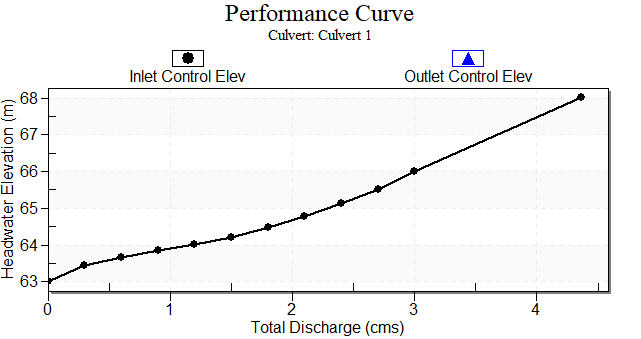

# HECRAS

HECRAS claims that it can handle negatively sloped culvert better than FWHA method.

The file is at: **./data/hecras/negative_slope.prj**

The results are copy and pasted into a csv file: **./data/hecras/negative_slope.csv**

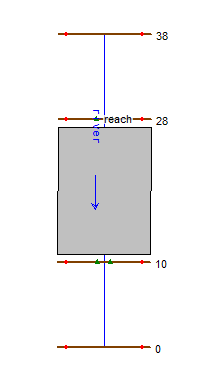

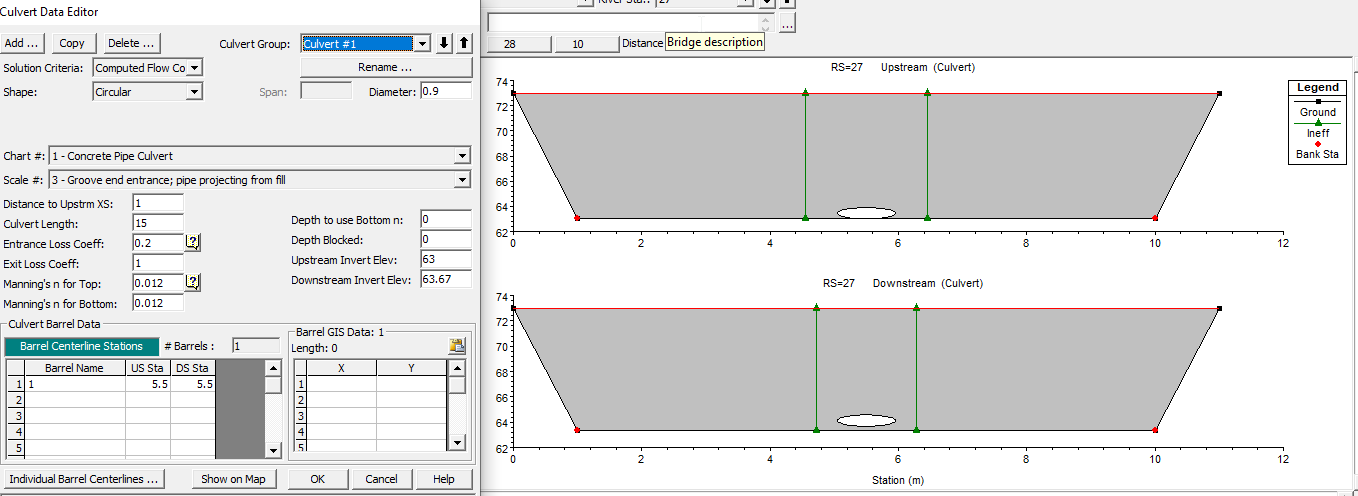

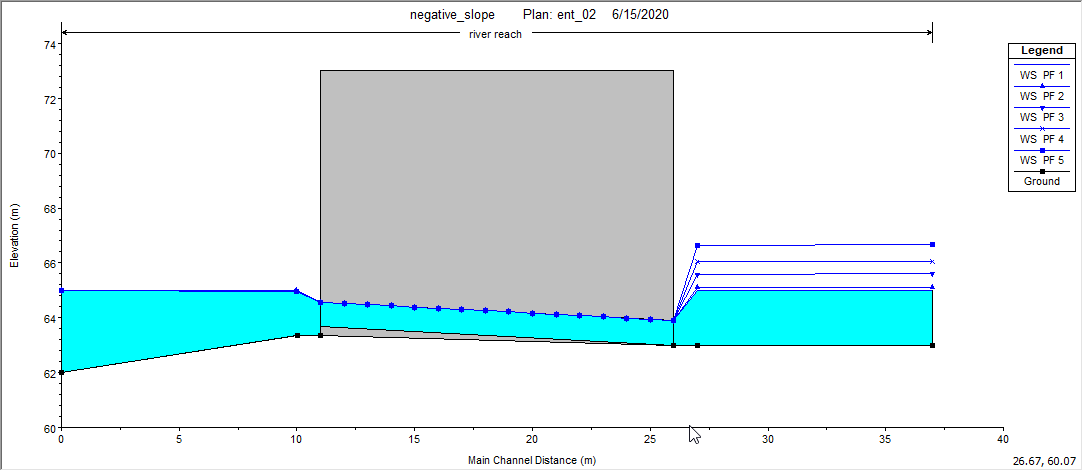

# SWMM5 Model

A swmm5 model is created: **./data/swmm5/adverse_slope.inp**

- For the culvert, don't set any losses, entering the culvert code should handle all these automatically.
- I loaded a hydrograph from 0 - 300 cfs in 6 hours.
- The depth vs total inflow in node 54RCP_2 should give the performance curve
- added 3.5ft tail water at outlet
- Had to use a hotstart file to get the starting level correct

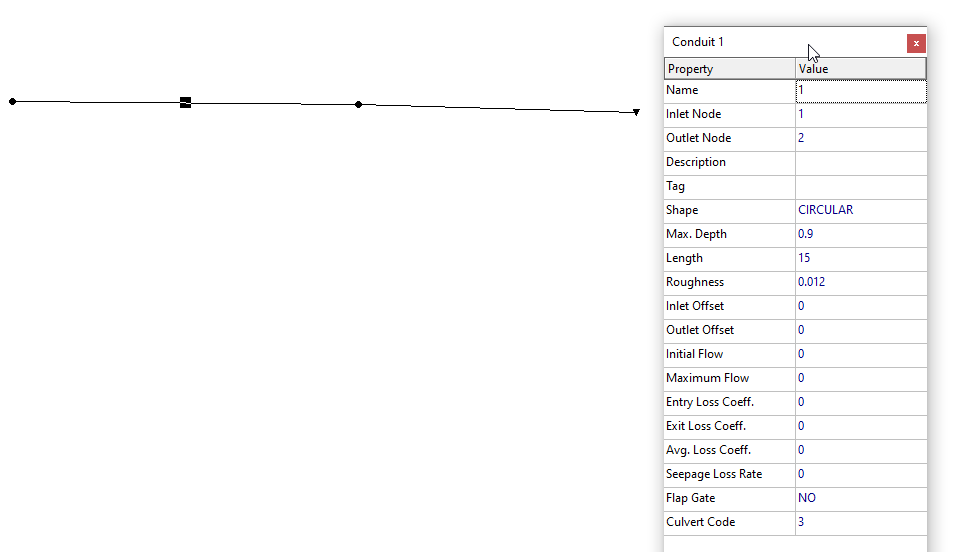

## Calibrate Losses

Since it is outlet control, the losses are playing an important role in the headwater calculation. 

As shown below, a combination of entrance and exit losses were compared,
- dashed lines are swmm5 models with various losses settings
- the orange is the outlet control calculated by HY8
- the green is the HECRAS result, which is very close to HY8
- the blue at the bottom is the inlet control line
- the highlighted two lines are the closest to the HY8 result

They are
- en=0.2 ex=1
- en=0.5 ex=0.5

I would use en=0.2 and ex=1, since that is the default values for culvert used in the HECRAS model.

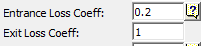

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
lib_path = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\source'
if lib_path not in sys.path:
    sys.path.append(lib_path)
sys.path

import swmm_tools as st


In [3]:
ws = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\references\culvert\data'
# run different combinations of the swmm5 losses
tmp_folder = os.path.join(ws, 'swmm5/template')
tmp_name = 'adverse_slope_loss.inp'

results = {}
for kentry in [0, 0.2, 0.5]: 
    for kexit in [0.5, 1, 2]:
        data = {'kentry': kentry, 'kexit': kexit}
        swmm5_inp = os.path.join(ws, 'swmm5/tmp/loss_en%s_ex%s.inp' % (kentry, kexit))
        st.render_input(tmp_folder, tmp_name, data, swmm5_inp)
        swmm5_out = os.path.join(ws, 'swmm5/tmp/loss_en%s_ex%s.out' % (kentry, kexit))
        st.run(swmm5_inp)
        results['en=%s ex=%s' % (kentry, kexit)] = st.extract_node(swmm5_out, '1')



... SWMM Version 5.3.0.dev0
... Run Complete1

... SWMM Version 5.3.0.dev0
... Run Complete1

... SWMM Version 5.3.0.dev0
... Run Complete1

... SWMM Version 5.3.0.dev0
... Run Complete1

... SWMM Version 5.3.0.dev0
... Run Complete1

... SWMM Version 5.3.0.dev0
... Run Complete1

... SWMM Version 5.3.0.dev0
... Run Complete1

... SWMM Version 5.3.0.dev0
... Run Complete1

... SWMM Version 5.3.0.dev0
... Run Complete1



... SWMM Version 5.3.0.dev0
... Run Complete1

... SWMM Version 5.3.0.dev0
... Run Complete1


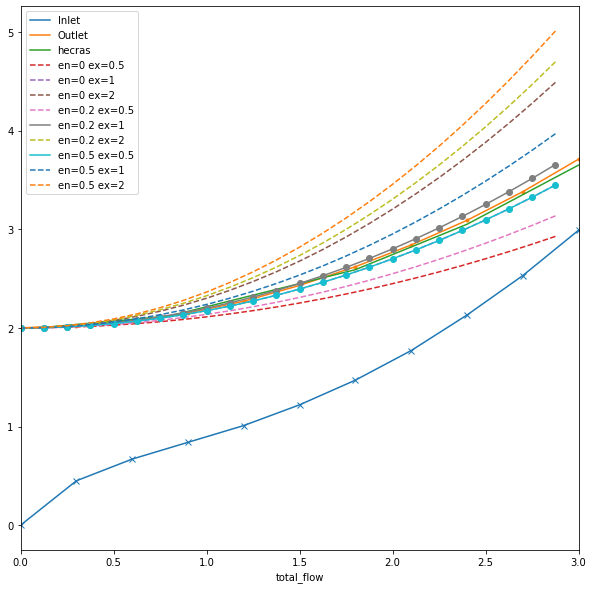

In [4]:
# plot the results in one chart

hy8_curve_csv = os.path.join(ws, 'hy8/negative_slope_performance_curve.csv')
hec_ras_csv = os.path.join(ws, 'hecras/negative_slope.csv')
swmm5_inp = os.path.join(ws, 'swmm5/adverse_slope.inp')
st.run(swmm5_inp)
swmm5_out = os.path.join(ws, 'swmm5/adverse_slope.out')
df_swmm = st.extract_node(swmm5_out, '1')
swmm5_inp = os.path.join(ws, 'swmm5/adverse_slope_loss.inp')
st.run(swmm5_inp)
swmm5_out = os.path.join(ws, 'swmm5/adverse_slope_loss.out')
df_swmm_loss = st.extract_node(swmm5_out, '1')

df = pd.read_csv(hy8_curve_csv)
df_ras = pd.read_csv(hec_ras_csv)
invert = 63
df_ras['base_depth'] = df_ras['BASE'] - invert
ax = df.plot(x='q', y='inlet', label='Inlet', style='x-', figsize=(10,10))
df.plot(x='q', y='outlet', label='Outlet', style='.-', ax=ax)
df_ras.plot(x='q', y='base_depth', label='hecras', ax=ax)
for k in results:
    if k in ['en=0.2 ex=1', 'en=0.5 ex=0.5']:
        results[k].plot(x='total_flow', y='depth', style='o-', label=k, ax=ax)
    else:
        results[k].plot(x='total_flow', y='depth', style='--', label=k, ax=ax)
plt.show()

# XPSWMM Model

Import the xpx file into XPSWMM and run the model. Similarly, XPSWMM is sensitive to the entrance/exit losses.

Model:**./data/xpswmm/adverse_slope.zip**

Results: **./data/xpswmm/adverse_slope.csv**


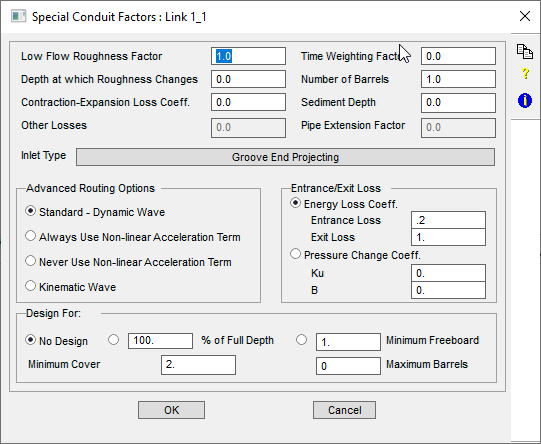

As shown below, 
* dashed lines are for the different losses
* en=0.2 and ex=1 gives good result.

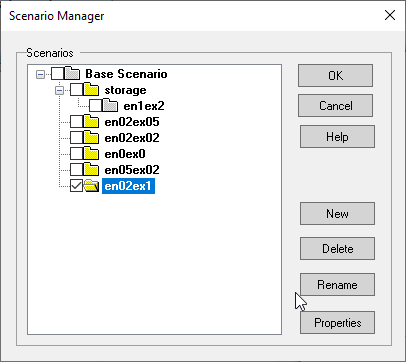

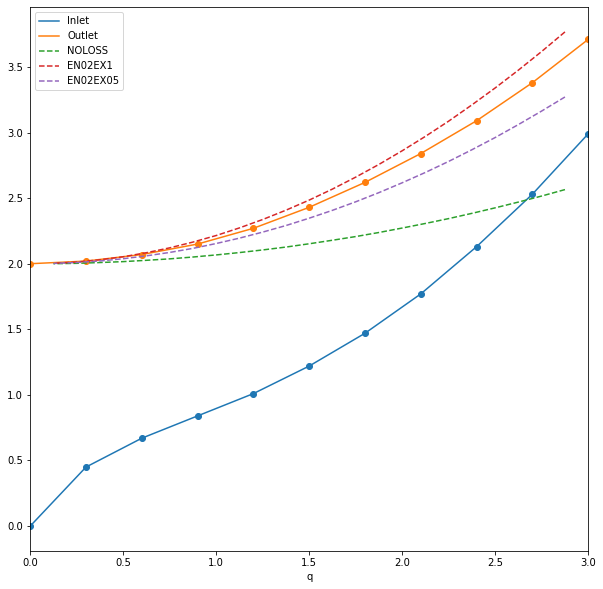

In [5]:
hy8_curve_csv = os.path.join(ws, 'hy8/negative_slope_performance_curve.csv')
xpswmm_csv =  os.path.join(ws, 'xpswmm/adverse_slope.csv')

df = pd.read_csv(hy8_curve_csv)
df_xp = pd.read_csv(xpswmm_csv)
invert = 63
scenarios = ['NOLOSS', 'EN02EX1', 'EN02EX05']
for sc in scenarios:
    df_xp[sc] = df_xp[sc] - invert

ax = df.plot(x='q', y='inlet', label='Inlet', style='o-', figsize=(10,10))
df.plot(x='q', y='outlet', label='Outlet', style='o-', ax=ax)
for sc in scenarios:
    df_xp.plot(x='q', y=sc, label=sc, style='--', ax=ax)
plt.show()

# Conclusion

For this example, HECRAS and HY8 give very similar results using default settings. For SWMM5 and XPSWMM, the entrance/exit losses need to be adjusted to match the HY8 curves.

As shown in the figure below,
- using the HERAS default values of entrance = 0.2 and exit = 1, SWMM5 and XPSWMM can produce similar results
- dahsed line is HY8 result
- both XPSWMM and swmm5 overestimes the headwater depth, and XPSWMM is slightly higher than SWMM5
- HECRAS is pretty close to the HY8 result


... SWMM Version 5.3.0.dev0
... Run Complete1


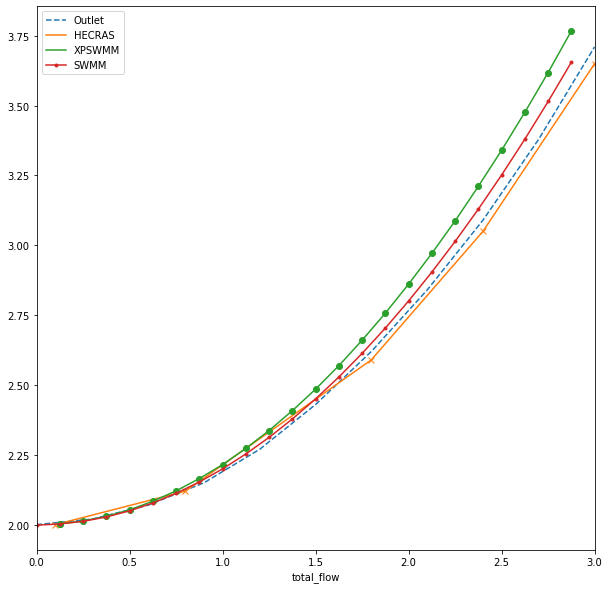

In [6]:
ws = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\references\culvert\data'
hy8_curve_csv = os.path.join(ws, 'hy8/negative_slope_performance_curve.csv')
hec_ras_csv = os.path.join(ws, 'hecras/negative_slope.csv')
xpswmm_csv =  os.path.join(ws, 'xpswmm/adverse_slope.csv')
invert = 63

swmm5_inp = os.path.join(ws, 'swmm5/adverse_slope_en02ex1.inp')
st.run(swmm5_inp)
swmm5_out = os.path.join(ws, 'swmm5/adverse_slope_en02ex1.out')
df_swmm_loss = st.extract_node(swmm5_out, '1')

df = pd.read_csv(hy8_curve_csv)
df_ras = pd.read_csv(hec_ras_csv)
df_xp = pd.read_csv(xpswmm_csv)
df_xp['depth'] = df_xp['EN02EX1'] - invert

df_ras['base_depth'] = df_ras['BASE'] - invert

# ax = df.plot(x='q', y='inlet', label='Inlet', style='x-', figsize=(10,10))
ax = df.plot(x='q', y='outlet', label='Outlet', style='--', figsize=(10,10))
df_ras.plot(x='q', y='base_depth', label='HECRAS', style='x-', ax=ax)
df_xp.plot(x='q', y='depth', label='XPSWMM', style='o-', ax=ax)
df_swmm_loss.plot(x='total_flow', y='depth', style='.-', label='SWMM', ax=ax)
plt.show()